# Пайплайн

## Imports

In [1]:
% load_ext autoreload
% autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from src.data.data_transformers import DataTransformer
from src.data.data_loaders import DataLoader

from src.models.models import ClassifierBoostingModel, BaseModel
from src.scorers.scorer import ROIScorer
from configs.paths import RAW_DATA_DIR, FEATURES_PATH, RAW_FUTURE_PATH

import yaml
from tqdm import tqdm
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

% matplotlib inline
pd.set_option('display.max_columns', None)

# pandas_display_options = {'show_dimensions': True,
#                           'precision': 2,
#                           'max_rows': 20
#                          }
#
# for option, value in pandas_display_options.items():
#     pd.set_option(f"display.{option}", value)

UsageError: Line magic function `%` not found.


# PATHS

In [3]:
print(RAW_DATA_DIR, FEATURES_PATH)

data/raw data/features.yaml


## Load data

In [4]:
with open(Path('../') / FEATURES_PATH) as f:
    all_features_dict = yaml.safe_load(f)

In [5]:
% % time
loader = DataLoader(train_dir=Path('../') / RAW_DATA_DIR)
raw_train_data, raw_future_data = loader()

CPU times: user 4.34 s, sys: 516 ms, total: 4.86 s
Wall time: 5.43 s


In [6]:
raw_train_data.sample(10)

,date,time,country,league,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,...,away_top11_nationality,away_top11_height,away_top11_foot,away_top11_joined_days,away_top11_signed_from,away_top11_market_value,league_type,day,week,timestamp_match
38889,2020-11-07 14:00:00,14:00,italy,serie-c,US Grosseto 1912,Carrarese Calcio 1908,2.79,2.96,2.55,1.44,...,italy,189.0,-,53.0,Piacenza Calcio 1919,175000.0,league,2020-11-07,45,1604757600
28346,2019-08-10 14:00:00,14:00,england,league-two,Cambridge United,Newport County,2.97,3.28,2.60,1.57,...,england,188.0,-,291.0,Without Club,100000.0,league,2019-08-10,32,1565445600
42817,2021-02-17 14:00:00,14:00,italy,serie-c,US Grosseto 1912,US Alessandria Calcio 1912,3.60,3.32,1.96,1.73,...,italy,183.0,right,161.0,Trapani Calcio,275000.0,league,2021-02-17,7,1613570400
40837,2020-12-23 14:00:00,14:00,italy,serie-c,UC AlbinoLeffe,Piacenza Calcio 1919,2.46,2.85,3.04,1.32,...,italy,182.0,right,97.0,Roma Primavera,175000.0,league,2020-12-23,52,1608732000
2986,2016-12-09 19:00:00,19:00,france,national,Paris FC,US Boulogne,2.64,2.82,2.51,1.39,...,france,177.0,left,161.0,US Saint-Malo,175000.0,league,2016-12-09,49,1481310000
43002,2021-02-21 13:00:00,13:00,spain,laliga2,CD Leganés,CD Tenerife,2.19,2.87,3.96,1.24,...,spain,186.0,right,2973.0,CD Tenerife B,400000.0,league,2021-02-21,7,1613912400
51580,2022-01-25 19:45:00,19:45,england,national-league,Bromley FC,Woking FC,1.96,3.70,3.52,1.27,...,england,193.0,-,208.0,Crawley Town,0.0,league,2022-01-25,4,1643139900
35905,2020-03-08 20:00:00,20:00,italy,serie-b,Benevento Calcio,Delfino Pescara 1936,1.43,4.40,7.22,1.09,...,albania,175.0,right,607.0,Benevento Calcio,650000.0,league,2020-03-08,10,1583697600
33157,2019-12-20 19:00:00,19:00,france,ligue-2,LB Châteauroux,EA Guingamp,3.30,3.20,2.25,1.63,...,france,182.0,right,537.0,FC Metz,120000000.0,league,2019-12-20,51,1576868400
33744,2020-01-08 14:45:00,14:45,spain,primera-rfef,Celta Vigo B,Real Madrid Castilla,2.50,3.14,2.69,1.37,...,spain,185.0,-,921.0,Real Madrid U19,200000.0,league,2020-01-08,2,1578494700


In [7]:
def get_cv_data(data, start_from_season: str = '2017-2018',
                unit: str = 'days',
                days: int = 7,
                weeks: int = 1,
                benchmark_league: str = 'premier-league',
                start_date=None
                ):
    # start_df = data.loc[data.season < start_from_season]
    if start_date:
        start_time = data[data.day == start_date].timestamp_date.min()
    else:
        start_time = data[(data.season == start_from_season) & (data.league == benchmark_league)].timestamp_date.min()
    finish_time = data.timestamp_date.max()

    window = 24 * 3600
    if unit == 'days':
        window *= days
    elif unit == 'weeks':
        window *= weeks * 7

    for period in range(start_time, finish_time, window):
        train_cv = data.loc[data.timestamp_date < period]
        val_cv = data.loc[(data.timestamp_date > period) & (data.timestamp_date <= period + window)]
        yield train_cv, val_cv



In [8]:
def base_data_preprocess(data):
    preprocessed_data = data.copy()
    # preprocessed_data = preprocessed_data.sort_values(by='timestamp_date')
    # preprocessed_data = preprocessed_data.drop(columns=['date', 'link'])
    drop_index = preprocessed_data[preprocessed_data.home_goalkeepers_average_age.isna()].index
    preprocessed_data = preprocessed_data.drop(index=drop_index)

    return preprocessed_data

In [106]:
train_data = base_data_preprocess(raw_train_data)

In [107]:
train_data

,date,time,country,league,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,...,away_top11_nationality,away_top11_height,away_top11_foot,away_top11_joined_days,away_top11_signed_from,away_top11_market_value,league_type,day,week,timestamp_match
0,2016-09-19 18:30:00,18:30,italy,serie-b,Cesena FC,US Salernitana 1919,2.21,2.40,4.90,1.14,...,italy,180.0,left,76.0,Ternana Calcio,650000.0,league,2016-09-19,38,1474309800
1,2016-09-19 18:30:00,18:30,italy,serie-c,AS Giana Erminio,US Pistoiese 1921,2.87,2.23,3.42,1.24,...,italy,182.0,left,41.0,Empoli FC,150000.0,league,2016-09-19,38,1474309800
2,2016-09-19 18:30:00,18:30,france,ligue-2,RC Strasbourg Alsace,Red Star FC,2.36,2.18,5.30,1.12,...,france,185.0,right,1162.0,ES Uzès Pont du Gard,400000.0,league,2016-09-19,38,1474309800
3,2016-09-19 18:45:00,18:45,italy,serie-c,ACR Messina,Foggia Calcio,4.56,2.44,2.17,1.58,...,italy,182.0,right,1541.0,Paganese Calcio 1926,250000.0,league,2016-09-19,38,1474310700
4,2016-09-20 15:30:00,15:30,germany,2-bundesliga,1.FC Nuremberg,SpVgg Greuther Fürth,2.24,3.56,3.38,1.34,...,germany,180.0,right,760.0,Eintracht Braunschweig,500000.0,league,2016-09-20,38,1474385400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55589,2022-06-11 16:00:00,16:00,spain,primera-rfef-promotion-play-offs,Deportivo de La Coruña,Albacete Balompié,1.65,3.45,5.90,1.12,...,-,0.0,-,0.0,-,0.0,league,2022-06-11,23,1654963200
55590,2022-06-11 19:00:00,19:00,spain,primera-rfef-promotion-play-offs,Villarreal CF B,Gimnàstic de Tarragona,2.09,3.15,3.61,1.22,...,-,0.0,-,0.0,-,0.0,league,2022-06-11,23,1654974000
55591,2022-06-11 19:00:00,19:00,spain,laliga2,Girona FC,CD Tenerife,2.17,2.92,4.00,1.25,...,-,0.0,-,0.0,-,0.0,league,2022-06-11,23,1654974000
55592,2022-06-12 19:15:00,19:15,italy,serie-c,US Palermo,Calcio Padova,2.14,3.08,3.53,1.27,...,-,0.0,-,0.0,-,0.0,league,2022-06-12,23,1655061300


In [108]:
use_features = ['day',
                'time',
                'country',
                'league',
                'home_team',
                'away_team',
                'season',
                'day_of_week',
                'home_manager_name',
                'away_manager_name',
                'home_manager_country',
                'away_manager_country',
                'home_stadium',
                'home_city',
                'away_city',
                'league_type',
                'is_derby',
                'month',
                'home_win_rate',
                'draw_rate',
                'away_win_rate',
                'home_double_chance_rate',
                'away_double_chance_rate',
                'no_draw_rate',
                'total_over_1_rate',
                'total_under_1_rate',
                'total_over_15_rate',
                'total_under_15_rate',
                'total_over_2_rate',
                'total_under_2_rate',
                'total_over_25_rate',
                'total_under_25_rate',
                'total_over_3_rate',
                'total_under_3_rate',
                'total_over_35_rate',
                'total_under_35_rate',
                'both_team_to_score_yes',
                'both_team_to_score_no',
                'home_handicap_0',
                'away_handicap_0',
                'home_handicap_minus_15',
                'away_handicap_minus_15',
                'home_handicap_minus_1',
                'away_handicap_minus_1',
                'home_handicap_plus_15',
                'away_handicap_plus_15',
                'home_handicap_plus_1',
                'away_handicap_plus_1',
                'league_level',
                'year',
                'timestamp_date',
                'home_squad_size',
                'home_average_age',
                'home_amount_of_foreigners',
                'home_e_market_value',
                'home_total_market_value',
                'away_squad_size',
                'away_average_age',
                'away_amount_of_foreigners',
                'away_e_market_value',
                'away_total_market_value',
                'home_manager_working_days',
                'away_manager_working_days',
                'home_manager_start_date',
                'home_manager_birthday',
                'away_manager_start_date',
                'away_manager_birthday',
                'home_stadium_capacity',
                'home_goalkeepers_average_age',
                'home_defenders_average_age',
                'home_midfields_average_age',
                'home_attacks_average_age',
                'home_goalkeepers_total_market_value',
                'home_defenders_total_market_value',
                'home_midfields_total_market_value',
                'home_attacks_total_market_value',
                'home_goalkeepers_e_market_value',
                'home_defenders_e_market_value',
                'home_midfields_e_market_value',
                'home_attacks_e_market_value',
                'away_goalkeepers_average_age',
                'away_defenders_average_age',
                'away_midfields_average_age',
                'away_attacks_average_age',
                'away_goalkeepers_total_market_value',
                'away_defenders_total_market_value',
                'away_midfields_total_market_value',
                'away_attacks_total_market_value',
                'away_goalkeepers_e_market_value',
                'away_defenders_e_market_value',
                'away_midfields_e_market_value',
                'away_attacks_e_market_value',
                'home_last_winter_window_departures_average_age',
                'home_last_winter_window_departures_sum',
                'home_last_winter_window_departures_total_market_value',
                'home_last_winter_window_arrivals_average_age',
                'home_last_winter_window_arrivals_sum',
                'home_last_winter_window_arrivals_total_market_value',
                'home_last_summer_window_departures_average_age',
                'home_last_summer_window_departures_sum',
                'home_last_summer_window_departures_total_market_value',
                'home_last_summer_window_arrivals_average_age',
                'home_last_summer_window_arrivals_sum',
                'home_last_summer_window_arrivals_total_market_value',
                'away_last_winter_window_departures_average_age',
                'away_last_winter_window_departures_sum',
                'away_last_winter_window_departures_total_market_value',
                'away_last_winter_window_arrivals_average_age',
                'away_last_winter_window_arrivals_sum',
                'away_last_winter_window_arrivals_total_market_value',
                'away_last_summer_window_departures_average_age',
                'away_last_summer_window_departures_sum',
                'away_last_summer_window_departures_total_market_value',
                'away_last_summer_window_arrivals_average_age',
                'away_last_summer_window_arrivals_sum',
                'away_last_summer_window_arrivals_total_market_value',
                'home_scored',
                'away_scored',
                'home_manager_age',
                'away_manager_age',
                'timestamp_match'
                ]

In [109]:
print(len(use_features))

121


In [110]:
train_data = train_data[use_features]

In [111]:
train_data

,day,time,country,league,home_team,away_team,season,day_of_week,home_manager_name,away_manager_name,...,away_last_summer_window_departures_sum,away_last_summer_window_departures_total_market_value,away_last_summer_window_arrivals_average_age,away_last_summer_window_arrivals_sum,away_last_summer_window_arrivals_total_market_value,home_scored,away_scored,home_manager_age,away_manager_age,timestamp_match
0,2016-09-19,18:30,italy,serie-b,Cesena FC,US Salernitana 1919,2016-2017,Monday,Massimo Drago,Giuseppe Sannino,...,300000.0,7.150000e+08,24.0,900000.0,9.580000e+08,0,0,16638.0,21692.0,1474309800
1,2016-09-19,18:30,italy,serie-c,AS Giana Erminio,US Pistoiese 1921,2016-2017,Monday,Cesare Albè,Gian Marco Remondina,...,1000.0,2.830000e+08,22.2,0.0,3.550000e+08,0,0,24318.0,21358.0,1474309800
2,2016-09-19,18:30,france,ligue-2,RC Strasbourg Alsace,Red Star FC,2016-2017,Monday,Thierry Laurey,Rui Almeida,...,0.0,8.550000e+08,23.3,0.0,7.950000e+08,0,0,19211.0,17157.0,1474309800
3,2016-09-19,18:45,italy,serie-c,ACR Messina,Foggia Calcio,2016-2017,Monday,Salvatore Marra,Giovanni Stroppa,...,0.0,2.530000e+08,23.8,300000.0,2.550000e+08,1,2,15618.0,17771.0,1474310700
4,2016-09-20,15:30,germany,2-bundesliga,1.FC Nuremberg,SpVgg Greuther Fürth,2016-2017,Tuesday,Alois Schwartz,Stefan Ruthenbeck,...,110000000.0,5.850000e+08,22.7,0.0,6.180000e+08,1,2,18074.0,16225.0,1474385400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55589,2022-06-11,16:00,spain,primera-rfef-promotion-play-offs,Deportivo de La Coruña,Albacete Balompié,2022-2023,Saturday,Borja Jiménez,Rubén de la Barrera,...,250000.0,7.850000e+08,24.6,0.0,5.500000e+08,1,1,13655.0,13658.0,1654963200
55590,2022-06-11,19:00,spain,primera-rfef-promotion-play-offs,Villarreal CF B,Gimnàstic de Tarragona,2022-2023,Saturday,Miguel Álvarez,Raúl Agné,...,0.0,2.030000e+08,24.5,0.0,2.080000e+08,2,0,23457.0,19011.0,1654974000
55591,2022-06-11,19:00,spain,laliga2,Girona FC,CD Tenerife,2022-2023,Saturday,Míchel,Luis Miguel Ramis,...,0.0,9.400000e+08,25.5,200000.0,1.135000e+09,0,0,17026.0,18949.0,1654974000
55592,2022-06-12,19:15,italy,serie-c,US Palermo,Calcio Padova,2022-2023,Sunday,Silvio Baldini,Massimo Oddo,...,0.0,5.800000e+08,25.0,385000.0,6.340000e+08,1,0,23285.0,16799.0,1655061300


In [112]:
numeric_features = tuple(train_data.select_dtypes(include=['int', 'float']).columns)

categorical_features = tuple(train_data.select_dtypes(include=['object']).columns)

features = {'cat_features': categorical_features,
            'num_features': numeric_features,
            'grouped_features': all_features_dict
            }


targets = ['home_scored', 'away_scored']

transformer_context = {'data': train_data,
                       'targets': targets
                       }

In [113]:
transformer = DataTransformer(transformer_context)
train = transformer.run_logic()
train = train.reset_index(drop=True)

cv_scorer = ROIScorer()

In [114]:
train

,day,time,country,league,home_team,away_team,season,day_of_week,home_manager_name,away_manager_name,...,away_last_summer_window_departures_total_market_value,away_last_summer_window_arrivals_average_age,away_last_summer_window_arrivals_sum,away_last_summer_window_arrivals_total_market_value,home_manager_age,away_manager_age,timestamp_match,result_target,total_target,both_target
0,2016-09-19,18:30,italy,serie-b,Cesena FC,US Salernitana 1919,2016-2017,Monday,Massimo Drago,Giuseppe Sannino,...,7.150000e+08,24.0,900000.0,9.580000e+08,16638.0,21692.0,1474309800,1,0,0
1,2016-09-19,18:30,italy,serie-c,AS Giana Erminio,US Pistoiese 1921,2016-2017,Monday,Cesare Albè,Gian Marco Remondina,...,2.830000e+08,22.2,0.0,3.550000e+08,24318.0,21358.0,1474309800,1,0,0
2,2016-09-19,18:30,france,ligue-2,RC Strasbourg Alsace,Red Star FC,2016-2017,Monday,Thierry Laurey,Rui Almeida,...,8.550000e+08,23.3,0.0,7.950000e+08,19211.0,17157.0,1474309800,1,0,0
3,2016-09-19,18:45,italy,serie-c,ACR Messina,Foggia Calcio,2016-2017,Monday,Salvatore Marra,Giovanni Stroppa,...,2.530000e+08,23.8,300000.0,2.550000e+08,15618.0,17771.0,1474310700,0,1,1
4,2016-09-20,15:30,germany,2-bundesliga,1.FC Nuremberg,SpVgg Greuther Fürth,2016-2017,Tuesday,Alois Schwartz,Stefan Ruthenbeck,...,5.850000e+08,22.7,0.0,6.180000e+08,18074.0,16225.0,1474385400,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54082,2022-06-11,16:00,spain,primera-rfef-promotion-play-offs,Deportivo de La Coruña,Albacete Balompié,2022-2023,Saturday,Borja Jiménez,Rubén de la Barrera,...,7.850000e+08,24.6,0.0,5.500000e+08,13655.0,13658.0,1654963200,1,0,1
54083,2022-06-11,19:00,spain,primera-rfef-promotion-play-offs,Villarreal CF B,Gimnàstic de Tarragona,2022-2023,Saturday,Miguel Álvarez,Raúl Agné,...,2.030000e+08,24.5,0.0,2.080000e+08,23457.0,19011.0,1654974000,3,0,0
54084,2022-06-11,19:00,spain,laliga2,Girona FC,CD Tenerife,2022-2023,Saturday,Míchel,Luis Miguel Ramis,...,9.400000e+08,25.5,200000.0,1.135000e+09,17026.0,18949.0,1654974000,1,0,0
54085,2022-06-12,19:15,italy,serie-c,US Palermo,Calcio Padova,2022-2023,Sunday,Silvio Baldini,Massimo Oddo,...,5.800000e+08,25.0,385000.0,6.340000e+08,23285.0,16799.0,1655061300,3,0,0


In [115]:
from catboost import CatBoostClassifier

model_params = {
    'n_estimators': 1000,
    'depth': 10,
    'learning_rate': 0.03,
    'loss_function': 'Logloss',
    'verbose': 250,
    'random_state': 322,
}

cv_model_result = CatBoostClassifier(**{
    'n_estimators': 500,
    'loss_function': 'MultiClass',
    'depth': 6,
    'learning_rate': 0.03,
    'verbose': 250,
    'random_state': 322,
})

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.0940125	total: 243ms	remaining: 2m 1s
250:	learn: 1.0012679	total: 1m 5s	remaining: 1m 5s
499:	learn: 0.9856360	total: 1m 51s	remaining: 0us
OrderedDict([('italy serie-a', {'roi': -62.75900000000001, 'amount': 6, 'percent': 16.7, 'coef': 2.23, 'win_bets': 1}), ('england national-league-south', {'roi': -48.519999999999996, 'amount': 7, 'percent': 28.6, 'coef': 1.8, 'win_bets': 2}), ('england league-two', {'roi': -42.724000000000004, 'amount': 3, 'percent': 33.3, 'coef': 1.72, 'win_bets': 1}), ('england national-league', {'roi': -37.125, 'amount': 8, 'percent': 25.0, 'coef': 2.515, 'win_bets': 2}), ('england efl-trophy', {'roi': -28.6, 'amount': 5, 'percent': 40.0, 'coef': 1.785, 'win_bets': 2}), ('spain laliga2', {'roi': -23.736400000000014, 'amount': 17, 'percent': 29.4, 'coef': 2.594, 'win_bets': 5}), ('england championship', {'roi': -18.082000000000008, 'amount': 3, 'percent': 33.3, 'coef': 2.46, 'win_bets': 1}), ('england national-league-north', {'roi': -18.0820000000000

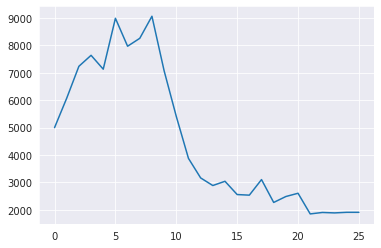

In [117]:
%%time
START_DATE = '2022-01-01'

iteration = 0
for cv_train, cv_test in get_cv_data(train, unit='weeks', start_date=START_DATE):
    drop_columns = ['result_target', 'total_target', 'both_target', 'day']
    cv_y_train_result = cv_train[['result_target']]
    cv_y_train_total = cv_train.total_target
    cv_y_train_both = cv_train.both_target

    cv_X_train = cv_train.drop(columns=drop_columns)

    cv_y_train_result = cv_y_train_result.astype(float)

    cv_model_result.fit(cv_X_train, cv_y_train_result, cat_features=categorical_features)
    # cv_model_total.fit(cv_X_train, cv_y_train_total)
    # cv_model_both.fit(cv_X_train, cv_y_train_both)

    result_target = cv_test.result_target
    total_target = cv_test.total_target
    both_target = cv_test.both_target
    cv_X_test = cv_test.drop(columns=drop_columns)

    preds_proba_result = cv_model_result.predict_proba(cv_X_test)
    # preds_proba_total = cv_model_total.predict_proba(cv_X_test)
    # preds_proba_both = cv_model_both.predict_proba(cv_X_test)

    cv_scorer.run_check(
        cv_X_test,
        result_target,
        total_target,
        both_target,
        preds_proba_result=preds_proba_result,
    )

    iteration += 1
    print(f"Iteration #{iteration} complete!")
    print('_______')

import matplotlib.pyplot as plt
dynamic_info, static_info = cv_scorer.return_info()
sns.lineplot(x=[i for i in range(len(static_info[2]))], y=static_info[2])
plt.savefig("low_features.png")

In [118]:
dynamic_info

([], [5000], [5000])

In [119]:
static_info

([{'initial_bank': 5000,
   'total_bank': 6076.0,
   'result_accepted_bets': 122,
   'result_average_win_coef': 3.3376744186046508,
   'result_win_rate': 0.3524590163934426,
   'total_accepted_bets': 0,
   'total_average_win_coef': 0,
   'total_win_rate': 0,
   'both_accepted_bets': 0,
   'both_average_win_coef': 0,
   'both_win_rate': 0,
   'skipped_bets': 0,
   'accepted_bets': 122,
   'profit': 1076.0,
   'percent_profit': 21.52,
   'win_bank': 5026.0,
   'lose_bank': -3950.0,
   'win_bets': 43,
   'result_win_bets': 43,
   'total_win_bets': 0,
   'both_win_bets': 0,
   'lose_bets': 79,
   'average_coef': 4.3375409836065595,
   'average_win_coef': 3.3376744186046508,
   'average_lose_coef': 4.881772151898733,
   'win_rate': 0.3524590163934426,
   'countries': {'spain laliga2': {'roi': -5.952199999999996,
     'amount': 217,
     'percent': 34.1,
     'coef': 2.758,
     'win_bets': 74},
    'england national-league-south': {'roi': -26.290000000000003,
     'amount': 92,
     'percen

In [47]:
for key, item in all_features_dict.items():
    if isinstance(item, dict):
        print(f"'{key}':")
        for inner_key in item.keys():
            print(f"\t'{inner_key}'")
    else:
        print(f"'{key}'")



'base_features'
'scored_features'
'result_coef_features'
'names':
	'team_names'
	'country_names'
	'city_names'
	'manager_names'
'manager_features'
'squad_features':
	'common_features'
	'detail_features'
'city_features'
'money_features'
'coefficients':
	'double_chance_features'
	'total_coef_features'
	'handicap_features'
	'both_scored_features'


In [16]:
raw_train_data.week.max()

53

In [120]:
def prepare_for_yaml(features_list) -> str:
    result_yaml = ''

    for feature in features_list:
        result_yaml += f"- '{feature}'\n"

    return result_yaml

# Трансформер

In [45]:
numeric_features = tuple(raw_train_data.select_dtypes(include=['int', 'float']).columns)
print(prepare_for_yaml(numeric_features[:10]))
print(f'Number of numeric features: {len(numeric_features)}')

- 'home_win_rate'
- 'draw_rate'
- 'away_win_rate'
- 'home_double_chance_rate'
- 'away_double_chance_rate'
- 'no_draw_rate'
- 'total_over_1_rate'
- 'total_under_1_rate'
- 'total_over_15_rate'
- 'total_under_15_rate'

Number of numeric features: 105


In [9]:
categorical_features = tuple(raw_train_data.select_dtypes(include=['object']).columns)
print(prepare_for_yaml(categorical_features))
print(f'Number of numeric features: {len(categorical_features)}')

- 'time'
- 'day_of_week'
- 'season'
- 'country'
- 'league'
- 'home_team'
- 'away_team'
- 'home_manager_name'
- 'away_manager_name'
- 'home_manager_country'
- 'away_manager_country'
- 'home_stadium'
- 'home_city'
- 'away_city'

Number of numeric features: 14


In [12]:
cat_features = ['time', 'day_of_week', 'season', 'league', 'home_stadium']

In [23]:
features = {'cat_features': cat_features,
            'num_features': numeric_features,
            'grouped_features': all_features_dict
            }

transformer_context = {'train': raw_train_data,
                       'test': raw_test_data,
                       'features': features,
                       'mode': 'fit',
                       'format': 'matches',
                       'target': 'result'
                       }

transformer = DataTransformer(transformer_context)

In [24]:
raw_test_data

,date,time,country,league,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,away_double_chance_rate,no_draw_rate,total_over_1_rate,total_under_1_rate,total_over_15_rate,total_under_15_rate,total_over_2_rate,total_under_2_rate,total_over_25_rate,total_under_25_rate,total_over_3_rate,total_under_3_rate,total_over_35_rate,total_under_35_rate,both_team_to_score_yes,both_team_to_score_no,home_handicap_0,away_handicap_0,home_handicap_minus_15,away_handicap_minus_15,home_handicap_minus_1,away_handicap_minus_1,home_handicap_plus_15,away_handicap_plus_15,home_handicap_plus_1,away_handicap_plus_1,home_first_half_handicap_0,away_first_half_handicap_0,home_first_half_handicap_minus_15,away_first_half_handicap_minus_15,home_first_half_handicap_minus_1,away_first_half_handicap_minus_1,home_first_half_handicap_plus_15,away_first_half_handicap_plus_15,home_first_half_handicap_plus_1,away_first_half_handicap_plus_1,home_second_half_handicap_0,away_second_half_handicap_0,home_second_half_handicap_minus_15,away_second_half_handicap_minus_15,home_second_half_handicap_minus_1,away_second_half_handicap_minus_1,home_second_half_handicap_plus_15,away_second_half_handicap_plus_15,home_second_half_handicap_plus_1,away_second_half_handicap_plus_1,home_first_half_win_rate,draw_first_half_rate,away_first_half_win_rate,home_second_half_win_rate,draw_second_half_rate,away_second_half_win_rate,home_double_chance_first_half_rate,away_double_chance_first_half_rate,no_draw_first_half_rate,home_double_chance_second_half_rate,away_double_chance_second_half_rate,no_draw_second_half_rate,total_first_half_over_05_rate,total_first_half_under_05_rate,total_first_half_over_1_rate,total_first_half_under_1_rate,total_first_half_over_15_rate,total_first_half_under_15_rate,total_first_half_over_2_rate,total_first_half_under_2_rate,total_second_half_over_05_rate,total_second_half_under_05_rate,total_second_half_over_1_rate,total_second_half_under_1_rate,total_second_half_over_15_rate,total_second_half_under_15_rate,total_second_half_over_2_rate,total_second_half_under_2_rate,both_team_to_score_first_half_yes,both_team_to_score_first_half_no,both_team_to_score_second_half_yes,both_team_to_score_second_half_no,odd,even,odd_first,odd_second,even_first,even_second,correct_score10,correct_score20,correct_score21,correct_score30,correct_score31,correct_score32,correct_score40,correct_score41,correct_score00,correct_score11,correct_score22,correct_score33,correct_score01,correct_score02,correct_score12,correct_score03,correct_score13,correct_score23,correct_score04,correct_score14,home_home,home_draw,home_away,draw_home,draw_draw,draw_away,away_home,away_draw,away_away,league_level,season,day_of_week,month,year,home_squad_size,home_average_age,home_amount_of_foreigners,home_e_market_value,home_total_market_value,away_squad_size,away_average_age,away_amount_of_foreigners,away_e_market_value,away_total_market_value,home_manager_working_days,away_manager_working_days,home_manager_name,away_manager_name,home_manager_start_date,home_manager_birthday,home_manager_country,away_manager_start_date,away_manager_birthday,away_manager_country,home_is_manager_and_league_same_country,away_is_manager_and_league_same_country,home_stadium,home_stadium_capacity,home_city,away_city,is_derby,home_goalkeepers_average_age,home_defenders_average_age,home_midfields_average_age,home_attacks_average_age,home_goalkeepers_total_market_value,home_defenders_total_market_value,home_midfields_total_market_value,home_attacks_total_market_value,home_goalkeepers_e_market_value,home_defenders_e_market_value,home_midfields_e_market_value,home_attacks_e_market_value,away_goalkeepers_average_age,away_defenders_average_age,away_midfields_average_age,away_attacks_average_age,away_goalkeepers_total_market_value,away_defenders_total_market_value,away_midfields_total_market_value,away_attacks_total_market_value,away_goalkeepers_e_market_value,away_defenders_e_market_value,away_midfields_e_mar

In [29]:
% % time
train, val, test, decode_labels, encode_labels = transformer.run_logic()

time
day_of_week
season
league
home_stadium


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [15]:
test.sample(5)

,date,time,day_of_week,season,country,league,league_level,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,away_double_chance_rate,no_draw_rate,total_over_1_rate,total_under_1_rate,total_over_15_rate,total_under_15_rate,total_over_2_rate,total_under_2_rate,total_over_25_rate,total_under_25_rate,total_over_3_rate,total_under_3_rate,total_over_35_rate,total_under_35_rate,both_team_to_score_yes,both_team_to_score_no,home_handicap_0,away_handicap_0,home_handicap_minus_15,away_handicap_minus_15,home_handicap_minus_1,away_handicap_minus_1,home_handicap_plus_15,away_handicap_plus_15,home_handicap_plus_1,away_handicap_plus_1,home_first_half_handicap_0,away_first_half_handicap_0,home_first_half_handicap_minus_15,away_first_half_handicap_minus_15,home_first_half_handicap_minus_1,away_first_half_handicap_minus_1,home_first_half_handicap_plus_15,away_first_half_handicap_plus_15,home_first_half_handicap_plus_1,away_first_half_handicap_plus_1,home_second_half_handicap_0,away_second_half_handicap_0,home_second_half_handicap_minus_15,away_second_half_handicap_minus_15,home_second_half_handicap_minus_1,away_second_half_handicap_minus_1,home_second_half_handicap_plus_15,away_second_half_handicap_plus_15,home_second_half_handicap_plus_1,away_second_half_handicap_plus_1,home_first_half_win_rate,draw_first_half_rate,away_first_half_win_rate,home_second_half_win_rate,draw_second_half_rate,away_second_half_win_rate,home_double_chance_first_half_rate,away_double_chance_first_half_rate,no_draw_first_half_rate,home_double_chance_second_half_rate,away_double_chance_second_half_rate,no_draw_second_half_rate,total_first_half_over_05_rate,total_first_half_under_05_rate,total_first_half_over_1_rate,total_first_half_under_1_rate,total_first_half_over_15_rate,total_first_half_under_15_rate,total_first_half_over_2_rate,total_first_half_under_2_rate,total_second_half_over_05_rate,total_second_half_under_05_rate,total_second_half_over_1_rate,total_second_half_under_1_rate,total_second_half_over_15_rate,total_second_half_under_15_rate,total_second_half_over_2_rate,total_second_half_under_2_rate,both_team_to_score_first_half_yes,both_team_to_score_first_half_no,both_team_to_score_second_half_yes,both_team_to_score_second_half_no,odd,even,odd_first,odd_second,even_first,even_second,correct_score10,correct_score20,correct_score21,correct_score30,correct_score31,correct_score32,correct_score40,correct_score41,correct_score00,correct_score11,correct_score22,correct_score33,correct_score01,correct_score02,correct_score12,correct_score03,correct_score13,correct_score23,correct_score04,correct_score14,home_home,home_draw,home_away,draw_home,draw_draw,draw_away,away_home,away_draw,away_away,home_manager_working_days,away_manager_working_days,home_manager_name,away_manager_name,home_manager_start_date,home_manager_birthday,home_manager_country,away_manager_start_date,away_manager_birthday,away_manager_country,month,home_squad_size,home_average_age,home_amount_of_foreigners,home_e_market_value,home_total_market_value,away_squad_size,away_average_age,away_amount_of_foreigners,away_e_market_value,away_total_market_value,home_stadium,home_stadium_capacity,home_city,away_city,is_derby,home_goalkeepers_average_age,home_defenders_average_age,home_midfields_average_age,home_attacks_average_age,home_goalkeepers_total_market_value,home_defenders_total_market_value,home_midfields_total_market_value,home_attacks_total_market_value,home_goalkeepers_e_market_value,home_defenders_e_market_value,home_midfields_e_market_value,home_attacks_e_market_value,home_is_manager_and_league_same_country,away_goalkeepers_average_age,away_defenders_average_age,away_midfields_average_age,away_attacks_average_age,away_goalkeepers_total_market_value,away_defenders_total_market_value,away_midfields_total_market_value,away_attacks_total_market_value,away_goalkeepers_e_market_value,away_defenders_e_market_value,away_midfields_e_market_value,away_attacks_e_market_value,away_is

In [16]:
train.target.value_counts()

3    4135
0    2947
1    2503
Name: target, dtype: int64

In [17]:
print(f"Class_0 rate {np.round(train.target.value_counts()[0] / train.shape[0], 2) * 100}%")
print(f"Class_1 rate {np.round(train.target.value_counts()[1] / train.shape[0], 2) * 100}%")
print(f"Class_3 rate {np.round(train.target.value_counts()[3] / train.shape[0], 2) * 100}%")

Class_0 rate 31.0%
Class_1 rate 26.0%
Class_3 rate 43.0%


# Model

In [18]:
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from catboost import CatBoostClassifier, Pool

In [19]:
cat_features = list(categorical_features)

model_data = {
    'train': train,
    'val': val,
    'test': test,
    'target': 'target',
    'cat_features': cat_features
}

In [ ]:
model_params = {'n_estimators': 1500,
                'learning_rate': 0.1,
                'loss_function': 'MultiClass',
                'max_depth': 4,
                'task_type': 'GPU',
                'early_stopping_rounds': 100,
                'verbose': 250
                }

model = BoostingModel(params=model_params, data=model_data)

model.fit()


In [ ]:
X_test = test.drop(columns=['target'])
y_test = test.target

preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

# Оценка качества

In [ ]:
print(f'Validation ACCURACY SCORE: {accuracy_score(y_test, preds_class)}')

In [ ]:
print(f'Validation ROC AUC SCORE: {roc_auc_score(y_test, preds_proba, multi_class="ovr")}')

In [ ]:
train_preds_class = model.model.predict(train.drop(columns=['target']))

In [ ]:
train_preds_df = pd.DataFrame()
train_preds_df['pred_class'] = train_preds_class.ravel()

In [ ]:
print('True target rate: ')
print(f"Class_0 rate {train.target.value_counts()[0] / train.shape[0]}")
print(f"Class_1 rate {train.target.value_counts()[1] / train.shape[0]}")
print(f"Class_3 rate {train.target.value_counts()[3] / train.shape[0]}")

In [ ]:
train_preds_df.pred_class.value_counts()

In [ ]:
print('Predict target rate:')
print(f"Class_0 rate {train_preds_df.pred_class.value_counts()[0] / train_preds_df.shape[0]}")
# print(f"Class_1 rate {train_preds_df.pred_class.value_counts()[1] / train_preds_df.shape[0]}")
print(f"Class_3 rate {train_preds_df.pred_class.value_counts()[3] / train_preds_df.shape[0]}")

In [ ]:
scorer = ROIChecker(decode_labels=decode_labels['team_names'])

In [ ]:
scorer.run_check(X_test, y_test, preds_proba, preds_class)

In [ ]:
X_val, y_val = val.drop(columns=['target']), val.target
preds_class_val = model.model.predict(X_val)
preds_proba_val = model.model.predict_proba(X_val)

In [ ]:
scorer.run_check(X_val, y_val, preds_proba_val, preds_class_val)

In [ ]:
dynamic_info, static_info = scorer.return_info()

In [ ]:
static_info[2]

In [ ]:
sns.lineplot(x=[i for i in range(len(static_info[2]))], y=static_info[2])

# Timeseries crossvalidation

In [20]:
train = train.reset_index()
train = train.drop(columns=['index'])
train.head(5)

,date,time,day_of_week,season,country,league,league_level,home_team,away_team,home_win_rate,draw_rate,away_win_rate,home_double_chance_rate,away_double_chance_rate,no_draw_rate,total_over_1_rate,total_under_1_rate,total_over_15_rate,total_under_15_rate,total_over_2_rate,total_under_2_rate,total_over_25_rate,total_under_25_rate,total_over_3_rate,total_under_3_rate,total_over_35_rate,total_under_35_rate,both_team_to_score_yes,both_team_to_score_no,home_handicap_0,away_handicap_0,home_handicap_minus_15,away_handicap_minus_15,home_handicap_minus_1,away_handicap_minus_1,home_handicap_plus_15,away_handicap_plus_15,home_handicap_plus_1,away_handicap_plus_1,home_first_half_handicap_0,away_first_half_handicap_0,home_first_half_handicap_minus_15,away_first_half_handicap_minus_15,home_first_half_handicap_minus_1,away_first_half_handicap_minus_1,home_first_half_handicap_plus_15,away_first_half_handicap_plus_15,home_first_half_handicap_plus_1,away_first_half_handicap_plus_1,home_second_half_handicap_0,away_second_half_handicap_0,home_second_half_handicap_minus_15,away_second_half_handicap_minus_15,home_second_half_handicap_minus_1,away_second_half_handicap_minus_1,home_second_half_handicap_plus_15,away_second_half_handicap_plus_15,home_second_half_handicap_plus_1,away_second_half_handicap_plus_1,home_first_half_win_rate,draw_first_half_rate,away_first_half_win_rate,home_second_half_win_rate,draw_second_half_rate,away_second_half_win_rate,home_double_chance_first_half_rate,away_double_chance_first_half_rate,no_draw_first_half_rate,home_double_chance_second_half_rate,away_double_chance_second_half_rate,no_draw_second_half_rate,total_first_half_over_05_rate,total_first_half_under_05_rate,total_first_half_over_1_rate,total_first_half_under_1_rate,total_first_half_over_15_rate,total_first_half_under_15_rate,total_first_half_over_2_rate,total_first_half_under_2_rate,total_second_half_over_05_rate,total_second_half_under_05_rate,total_second_half_over_1_rate,total_second_half_under_1_rate,total_second_half_over_15_rate,total_second_half_under_15_rate,total_second_half_over_2_rate,total_second_half_under_2_rate,both_team_to_score_first_half_yes,both_team_to_score_first_half_no,both_team_to_score_second_half_yes,both_team_to_score_second_half_no,odd,even,odd_first,odd_second,even_first,even_second,correct_score10,correct_score20,correct_score21,correct_score30,correct_score31,correct_score32,correct_score40,correct_score41,correct_score00,correct_score11,correct_score22,correct_score33,correct_score01,correct_score02,correct_score12,correct_score03,correct_score13,correct_score23,correct_score04,correct_score14,home_home,home_draw,home_away,draw_home,draw_draw,draw_away,away_home,away_draw,away_away,home_manager_working_days,away_manager_working_days,home_manager_name,away_manager_name,home_manager_start_date,home_manager_birthday,home_manager_country,away_manager_start_date,away_manager_birthday,away_manager_country,month,home_squad_size,home_average_age,home_amount_of_foreigners,home_e_market_value,home_total_market_value,away_squad_size,away_average_age,away_amount_of_foreigners,away_e_market_value,away_total_market_value,home_stadium,home_stadium_capacity,home_city,away_city,is_derby,home_goalkeepers_average_age,home_defenders_average_age,home_midfields_average_age,home_attacks_average_age,home_goalkeepers_total_market_value,home_defenders_total_market_value,home_midfields_total_market_value,home_attacks_total_market_value,home_goalkeepers_e_market_value,home_defenders_e_market_value,home_midfields_e_market_value,home_attacks_e_market_value,home_is_manager_and_league_same_country,away_goalkeepers_average_age,away_defenders_average_age,away_midfields_average_age,away_attacks_average_age,away_goalkeepers_total_market_value,away_defenders_total_market_value,away_midfields_total_market_value,away_attacks_total_market_value,away_goalkeepers_e_market_value,away_defenders_e_market_value,away_midfields_e_market_value,away_attacks_e_market_value,away_is

In [21]:
# current_features = list(train.filter(like='current').columns)

In [22]:
# base_cv_features = all_features_dict['base_features'] + current_features + ['target']
# base_train = train[base_cv_features]
# base_train.head()

In [23]:
# cat_features = [feature for feature in base_cv_features if feature in categorical_features]
# cat_features

In [24]:
# base_val = val[base_cv_features]
# base_test = test[base_cv_features]

In [25]:
def get_cv_data(train_data, train_initial_size=6000, window=250):
    for index in range(0, train_data.shape[0] - train_initial_size - window + 1, window):
        train_cv = train_data.iloc[:train_initial_size + index]
        val_cv = train_data.iloc[train_initial_size + index: train_initial_size + index + window]
        yield train_cv, val_cv

In [71]:
cv_scorer = ROIChecker(decode_labels=decode_labels['team_names'], roi_threshold=3)

In [72]:
model_params = {'n_estimators': 1500,
                'learning_rate': 0.1,
                'loss_function': 'MultiClass',
                'task_type': 'GPU',
                'early_stopping_rounds': 50,
                'verbose': 750
                }

cv_model = CatBoostClassifier(**model_params)

In [73]:
# cv_train_columns = {index:feature for index, feature in enumerate(list(cv_X_train.columns))}
# cv_train_columns

In [74]:
# cv_test_columns = {index:feature for index, feature in enumerate(list(cv_X_test.columns))}
# cv_test_columns

In [75]:
% % time
iteration = 0
for cv_train, cv_test in get_cv_data(train):
    cv_y_train = cv_train.target
    cv_X_train = cv_train.drop(columns=['target'])
    cv_y_test = cv_test.target
    cv_X_test = cv_test.drop(columns=['target'])

    cv_model.fit(cv_X_train, cv_y_train)

    preds_proba = cv_model.predict_proba(cv_X_test)
    preds_class = cv_model.predict(cv_X_test)

    cv_scorer.run_check(cv_X_test, cv_y_test, preds_proba, preds_class)

    iteration += 1
    print(f"Iretation #{iteration} complete!")
    print('_______')

0:	learn: 1.0833180	total: 15ms	remaining: 22.4s
750:	learn: 0.4328661	total: 9.26s	remaining: 9.24s
1499:	learn: 0.2159913	total: 18.4s	remaining: 0us
Iretation #1 complete!
_______
0:	learn: 1.0830689	total: 15.2ms	remaining: 22.8s
750:	learn: 0.4395692	total: 9.48s	remaining: 9.45s
1499:	learn: 0.2224395	total: 18.9s	remaining: 0us
Iretation #2 complete!
_______
0:	learn: 1.0829661	total: 11.9ms	remaining: 17.9s
750:	learn: 0.4556839	total: 9.38s	remaining: 9.36s
1499:	learn: 0.2341664	total: 19s	remaining: 0us
Iretation #3 complete!
_______
0:	learn: 1.0831753	total: 12.3ms	remaining: 18.4s
750:	learn: 0.4677382	total: 9.38s	remaining: 9.35s
1499:	learn: 0.2435869	total: 18.8s	remaining: 0us
Iretation #4 complete!
_______
0:	learn: 1.0831618	total: 15.3ms	remaining: 22.9s
750:	learn: 0.4730306	total: 9.46s	remaining: 9.44s
1499:	learn: 0.2475409	total: 18.9s	remaining: 0us
Iretation #5 complete!
_______
0:	learn: 1.0836538	total: 13.9ms	remaining: 20.8s
750:	learn: 0.4830966	total:

In [76]:
dynamic_info, static_info = cv_scorer.return_info()

In [77]:
for info in static_info[0]:
    print(info)

{'skipped_bets': 213, 'accepted_bets': 37, 'profit': 120.0, 'percent_profit': 12.0, 'initial_bank': 1000, 'total_bank': 1120.0, 'win_bank': 3220.0, 'lose_bank': -3100, 'win_bets': 6, 'lose_bets': 31, 'average_coef': 7.919729729729729, 'average_win_coef': 6.366666666666667, 'average_lose_coef': 8.220322580645158, 'win_rate': 0.16216216216216217}
{'skipped_bets': 209, 'accepted_bets': 41, 'profit': 736.0, 'percent_profit': 65.71428571428571, 'initial_bank': 1120.0, 'total_bank': 1856.0, 'win_bank': 4036.0, 'lose_bank': -3300, 'win_bets': 8, 'lose_bets': 33, 'average_coef': 9.101463414634146, 'average_win_coef': 6.045, 'average_lose_coef': 9.842424242424242, 'win_rate': 0.1951219512195122}
{'skipped_bets': 221, 'accepted_bets': 29, 'profit': 1359.0, 'percent_profit': 73.22198275862068, 'initial_bank': 1856.0, 'total_bank': 3215.0, 'win_bank': 3659.0, 'lose_bank': -2300, 'win_bets': 6, 'lose_bets': 23, 'average_coef': 8.25, 'average_win_coef': 7.098333333333333, 'average_lose_coef': 8.5504

<AxesSubplot:>

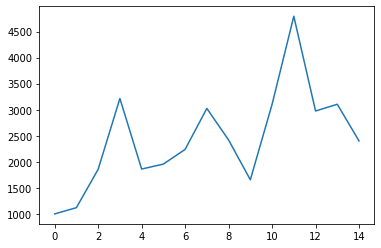

In [78]:
sns.lineplot(x=[i for i in range(len(static_info[2]))], y=static_info[2])

<AxesSubplot:>

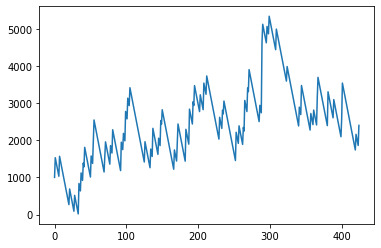

In [79]:
sns.lineplot(x=[i for i in range(len(static_info[1]))], y=static_info[1])

# Считаем ROI - "коэффициент выгодности ставки"

In [ ]:
class ROIChecker():
    def __init__(self, predictions):
        self.predictions = predictions

    def get_roi(self):
        self.predictions['home_win_ROI'] = self.predictions.home_win_rate * self.predictions.home_win_proba - 1
        self.predictions['away_win_ROI'] = self.predictions.away_win_rate * self.predictions.away_win_proba - 1
        self.predictions['draw_ROI'] = self.predictions.draw_rate * self.predictions.draw_proba - 1

        return self.predictions


In [ ]:
checker = ROIChecker(test_predictions)
roi_info = checker.get_roi()

In [ ]:
roi_info.head()

In [ ]:
def explain_roi_info(roi_info):
    roi_cols = ['home_win_ROI', 'away_win_ROI', 'draw_ROI']
    best_roi_df = pd.DataFrame()
    for index, row in roi_info.iterrows():
        print(f"Match #{index + 1}: {row.home_team} vs {row.away_team}")

        max_roi = np.max(roi_info.loc[index, roi_cols])
        current_choice = 'home_win_ROI'

        for col in roi_cols:
            if row[col] == max_roi:
                current_choice = col
        current_choice = ' '.join(current_choice.split('_')[:1])

        if max_roi > 0:
            print(f"Maximal ROI = {np.round(max_roi * 100, 2)}% on {current_choice}")

        else:
            print("Нет положительного ROI")

        print('_______________________________ \n')

        best_roi_df.loc[index, 'home_team'] = row.home_team
        best_roi_df.loc[index, 'away_team'] = row.away_team
        best_roi_df.loc[index, 'best_ROI'] = max_roi
        best_roi_df.loc[index, 'choice'] = current_choice
        best_roi_df.loc[index, 'home_win_rate'] = row.home_win_rate
        best_roi_df.loc[index, 'draw_rate'] = row.draw_rate
        best_roi_df.loc[index, 'away_win_rate'] = row.away_win_rate
        best_roi_df.loc[index, 'result'] = row.result
        best_roi_df.loc[index, 'predict'] = row.predict

    return best_roi_df

In [ ]:
best_roi_df = explain_roi_info(roi_info)

In [ ]:
best_roi_df

In [ ]:
def money_score(best_roi_df, bet=100):
    results = {'home': 3, 'draw': 1, 'away': 0}
    cols = {'home': 'home_win_rate', 'draw': 'draw_rate', 'away': 'away_win_rate'}
    profit = 0
    skipped_bets = 0
    accepted_bets = 0
    total_coef = 0
    win_coef = 0
    lose_coef = 0
    win_bets = 0
    lose_bets = 0
    total_bank = 0
    win_bank = 0
    lose_bank = 0

    for index, row in best_roi_df.iterrows():
        if row.best_ROI < 0:
            skipped_bets += 1
        else:
            accepted_bets += 1

            if results[row.choice] == row.result:

                current_profit = bet * (row[cols[row.choice]] - 1)
                profit += current_profit
                win_coef += row[cols[row.choice]]

                print(f'Match {row.home_team} vs {row.away_team}')
                print(row.choice, row[cols[row.choice]], current_profit)
                print(f'Match score ')
                print('_____________________________________________________\n')
                win_bank += current_profit
                win_bets += 1

            else:
                profit -= bet
                lose_bank -= bet
                lose_bets += 1
                lose_coef += row[cols[row.choice]]

            total_coef += row[cols[row.choice]]
            total_bank += bet

    average_win_coef = win_coef / win_bets

    average_lose_coef = lose_coef / lose_bets
    average_coef = total_coef / accepted_bets
    percent_profit = profit / total_bank * 100

    result = ((skipped_bets, accepted_bets),
              (profit, percent_profit),
              (total_bank, win_bank, lose_bank),
              (win_bets, lose_bets),
              (average_coef, average_win_coef, average_lose_coef))

    return result


In [ ]:
score = money_score(best_roi_df, 100)

In [ ]:
print(f'Skipped bets: {score[0][0]}\t Accepted bets: {score[0][1]}')
print(f"Win bets: {score[3][0]}\t Lose bets: {score[3][1]}")
print(f"Win bank: {score[2][1]}$\t Lose bank: {score[2][2]}$")

print(f"Average coefficient: {np.round(score[4][0], 2)}")
print(f"Avg win coef: {np.round(score[4][1], 2)}\t Avg lose coef: {np.round(score[4][2], 2)}")
print(f"Initial bank was {score[2][0]}$ \t Finish bank is {score[2][0] + np.round(score[1][0], 2)}$\n")
print('___________RESULT__________')
print(f" \tWe get + {np.round(score[1][1], 2)}% profit")
print(f" \tProfit: {score[1][0]}$")

# Влияние фичей на качество модели

In [ ]:
feature_importance = model.get_feature_importances()
feature_importance_df = pd.DataFrame()

feature_importance_df['feature'] = X_test.columns
feature_importance_df['importance'] = feature_importance

good_features = feature_importance_df[np.abs(feature_importance_df.importance) > 0].sort_values(by='importance',
                                                                                                ascending=False).head(
    30)
bad_features = feature_importance_df.sort_values(by='importance', ascending=True).head(30)

print(f'Number of features {X_test.shape[1]}')

In [ ]:
good_features

In [ ]:
bad_features

In [ ]:
test_predictions = pd.DataFrame()
test_predictions['home_team'] = X_test.home_team.map(decode_labels['team_names'])
test_predictions['away_team'] = X_test.away_team.map(decode_labels['team_names'])
test_predictions['home_win_proba'] = preds_proba[:, 0]
test_predictions['draw_proba'] = preds_proba[:, 1]
test_predictions['away_win_proba'] = preds_proba[:, 2]
test_predictions['home_win_rate'] = X_test.home_win_rate
test_predictions['draw_rate'] = X_test.draw_rate
test_predictions['away_win_rate'] = X_test.away_win_rate
test_predictions['result'] = y_test
test_predictions['predict'] = preds_class

In [ ]:
test_predictions

## Generating some features and testing hypotheses

# ПЕРЕДЕЛАТЬ! Считаем сезонные total :
- забитые
- пропущенные
- количество очков

In [ ]:
query = '((home_team == @team) | (away_team == @team)) & (season == @season) & (league == @league)'

season_data = pd.DataFrame()

total_features = train_data_base.copy()

for league in total_features.league.unique():

    for season in total_features.season.unique():

        season_league_data = total_features.query('(season == @season) & (league == @league)')

        for team in season_league_data.home_team.unique():

            season_data = season_league_data.query('((home_team == @team) | (away_team == @team))')

            total_points = 0
            total_scored = 0
            total_missed = 0

            for idx in season_data.index:

                if season_data.loc[idx, 'home_team'] == team:

                    total_points += season_data.loc[idx, 'target']
                    total_scored += season_data.loc[idx, 'home_scored']
                    total_missed += season_data.loc[idx, 'away_scored']

                else:

                    home = season_data.loc[idx, 'home_scored']
                    away = season_data.loc[idx, 'away_scored']

                    away_match_score = 3 if home < away else 1 if home == away else 0

                    total_points += away_match_score
                    total_scored += season_data.loc[idx, 'away_scored']
                    total_missed += season_data.loc[idx, 'home_scored']

            condition_home = ((total_features.home_team == team) & (total_features.season == season))
            condition_away = ((total_features.away_team == team) & (total_features.season == season))

            total_features.loc[condition_home, 'total_points_home'] = total_points
            total_features.loc[condition_away, 'total_points_away'] = total_points

            total_features.loc[condition_home, 'total_scored_home'] = total_scored
            total_features.loc[condition_away, 'total_scored_away'] = total_scored

            total_features.loc[condition_home, 'total_missed_home'] = total_missed
            total_features.loc[condition_away, 'total_missed_away'] = total_missed

            total_features.loc[condition_home, 'total_diff_home'] = total_scored - total_missed
            total_features.loc[condition_away, 'total_diff_away'] = total_scored - total_missed

            print(
                f"TEAM: {team} LEAGUE: {league} SEASON: {season}\ntotal points:{total_points}\ttotal scored:{total_scored}\ttotal missed:{total_missed}\ttotal_diff: {total_scored - total_missed}")
            print('_________')

total_features.tail()

In [ ]:
home_team_alltime = train_data_base.groupby(['home_team'], as_index=False).agg(
    home_mean_scored_season=('home_scored', 'mean'),
    home_mean_missed_season=('away_scored', 'mean')
)

away_team_alltime = train_data_base.groupby(['away_team'], as_index=False).agg(
    away_mean_scored_alltime=('home_scored', 'mean'),
    away_mean_missed_alltime=('away_scored', 'mean')
)

home_team_alltime.head()

In [ ]:
train_data_base = train_data_base.merge(home_team_alltime, how='left', on=['home_team', 'season'])
train_data_base = train_data_base.merge(away_team_alltime, how='left', on=['away_team', 'season'])

train_data_base.head()

# ПЕРЕДЕЛАТЬ! Личные встречи за все время забитые/пропущенные

In [ ]:
# personal_battles = train_with_names.groupby(['home_team', 'away_team'], as_index=False) \
#                         .agg(total_home_scored = ('home_scored', 'sum'),
#                             total_home_missed = ('away_scored', 'sum'),

#                             )

# personal_battles

# Разбиение фичей на группы

In [ ]:
enumerated_features = dict()

for idx, feature in enumerate(list(train_data.columns)):
    enumerated_features[idx] = feature

In [ ]:
enumerated_features

In [ ]:
base_features = list(train_data.iloc[0:2, 0:9].columns)
base_features.append(enumerated_features[126])
base_features.append(enumerated_features[127])
base_features.append(enumerated_features[208])
base_features.append(enumerated_features[209])
base_features.append('month')

print(prepare_for_yaml(base_features))

In [ ]:
squad_features = list(train_data.iloc[0:2, 143:153].columns)
print(prepare_for_yaml(squad_features))

In [ ]:
squad_detail_features = list(train_data.iloc[0:2, 158:208])
print(prepare_for_yaml(squad_detail_features[:10]))

In [ ]:
money_features = list(train_data.filter(like='market_value', axis=1).columns) + list(
    train_data.filter(like='s_sum', axis=1).columns)
print(prepare_for_yaml(money_features))

In [ ]:
city_features = list(train_data.iloc[0:2, 153:158].columns)
print(prepare_for_yaml(city_features))

In [ ]:
result_coef_features = [enumerated_features[9], enumerated_features[10], enumerated_features[11]]
print(prepare_for_yaml(result_coef_features))

In [ ]:
double_chance_features = list(train_data.filter(like='chance', axis=1).columns)
print(prepare_for_yaml(double_chance_features))

In [ ]:
total_coef_features = list(train_data.filter(like='total_over', axis=1).columns) + list(
    train_data.filter(like='total_under', axis=1).columns)
print(prepare_for_yaml(total_coef_features))

In [ ]:
handicap_features = list(train_data.iloc[0:2, 29:39].columns)
print(prepare_for_yaml(handicap_features))

In [ ]:
half_features = list(train_data.iloc[0:2, 39:91].columns)
print(prepare_for_yaml(half_features[:10]))

In [ ]:
odd_features = list(train_data.iloc[0:2, 91:97].columns)

print(prepare_for_yaml(odd_features))

In [ ]:
correct_score_features = list(train_data.filter(like='correct_score', axis=1).columns)
print(prepare_for_yaml(correct_score_features))

In [ ]:
time_match_features = list(train_data.iloc[0:2, 117:126].columns)
print(prepare_for_yaml(time_match_features))

In [ ]:
both_scored_features = list(train_data.iloc[0:2, 87:91].columns)
both_scored_features += list(train_data.iloc[0:2, 128:132].columns)
both_scored_features.append(enumerated_features[27])
both_scored_features.append(enumerated_features[28])

print(prepare_for_yaml(both_scored_features))

In [ ]:
manager_features = tuple(train_data.filter(like='manager', axis=1).columns)

print(prepare_for_yaml(manager_features))